In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from mario.match import Mario # main object
from mario.match_utils import eval_matching_accuracy # for evaluating matching accuracy
from mario.match import pipelined_mario # for running the overall pipeline

from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2022_12_07_new_multilin_panel/")

In [8]:
### Load the data
# Mapped CITE-seq ADT alone
path_cite = "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "mapped_cite_ari_adt_alone_all_cells.fea"
path_flow = "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_alone.fea"

# Read in the data
cite = pd.read_feather(path_cite).set_index("index")
flow = pd.read_feather(path_flow)

# Read the annotation
cite_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
flow_anno = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_alone_groups.csv", 
    header=None)

# Set up the annotation to fig class input
tmp_anno_cite = cite_anno[["cell", "ari_group"]]
tmp_anno_cite.columns = ["cell", "group"]
tmp_anno_flow = flow_anno
tmp_anno_flow.columns = ["cell", "group"]

In [10]:
tmp_anno_flow

,cell,group
0,0,CD127
1,1,CD127
2,2,CD127
3,3,CD127
4,4,CD127
...,...,...
22995,22995,Z
22996,22996,Z
22997,22997,Z
22998,22998,Z


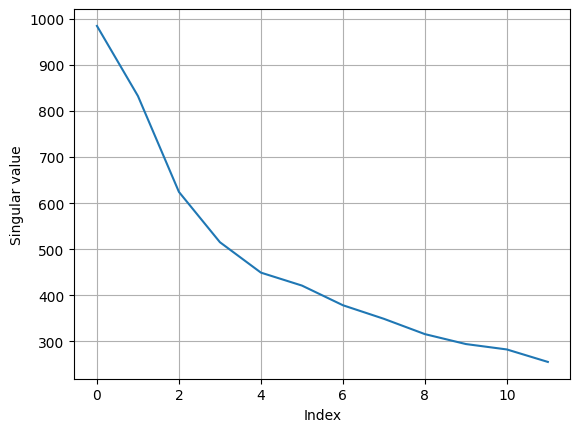

In [11]:
### Parameters for overlapping feature matching
# Construct the MARIO object
mario = Mario(cite, flow, normalization=False)
# compute distance matrix using overlapping features
_, singular_values = mario.compute_dist_ovlp(n_components=12)
# visualize singular values to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(singular_values))), singular_values)
ax.set(xlabel='Index', ylabel='Singular value')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

We use this plot to decide how many components to use during mathcing with overlapping features, similar to the concept used with Elbow plots during PCA reduction. From this plot any value **above 6** looks good, we choose 10 here.

In [12]:
# any value above six looks good; let us choose 10
_ = mario.compute_dist_ovlp(n_components=10)
# specify how many cells in df2 should be matched to one cell in df1, we use the standard 1v1 matching
mario.specify_matching_params(1)

**Optional**: We also provide the option to run the **MARIO** matching with sparsity. Running with sparsity could reduce the run time if the data size is large, and potentially be a denoising step. We provide a function find the best sparsity number to use:

In [22]:
# # [optional] check the minimum valid sparsity level
# mario.search_minimum_sparsity(mario.dist['ovlp'], slackness=1, init_sparsity=100, verbose=True)

Based on the result, any sparsity level > 104 will give valid matching, thus we will use 120 and perform matching with overlapping features:

*Note: the sparsity value is related (in ratio) to the amount of cells in n1.*

In [13]:
# any a sparsity level >= 1548 will give a valid matching 
# let us choose 1550
_ = mario.match_cells('ovlp', mode='dense') # sparsity=120,

In [14]:
_

[[12702],
 [13006],
 [13733],
 [13913],
 [6105],
 [13616],
 [13567],
 [13014],
 [6563],
 [13899],
 [12235],
 [7960],
 [2456],
 [7681],
 [7514],
 [6211],
 [13982],
 [13855],
 [7462],
 [7285],
 [6200],
 [7696],
 [9892],
 [13348],
 [7854],
 [13077],
 [13920],
 [19893],
 [8593],
 [6268],
 [6545],
 [12651],
 [9104],
 [6391],
 [22938],
 [7415],
 [12851],
 [13247],
 [12943],
 [13396],
 [12265],
 [13167],
 [13844],
 [12040],
 [13853],
 [13483],
 [7319],
 [12026],
 [13977],
 [13117],
 [6140],
 [7857],
 [6313],
 [13418],
 [13782],
 [8834],
 [13628],
 [13632],
 [13629],
 [13139],
 [7388],
 [12495],
 [8284],
 [13624],
 [13724],
 [13842],
 [19436],
 [8345],
 [13770],
 [13683],
 [13742],
 [13835],
 [13575],
 [13747],
 [13253],
 [13155],
 [13929],
 [2384],
 [13129],
 [2302],
 [2752],
 [11097],
 [641],
 [13712],
 [7055],
 [13862],
 [13985],
 [13010],
 [6587],
 [12260],
 [11420],
 [13707],
 [7671],
 [12431],
 [13036],
 [13541],
 [13509],
 [12306],
 [13308],
 [13538],
 [13057],
 [13302],
 [21923],
 [138

**Optional**: If you have the basic annotations of the cell types of the two datasets (the names are the same), we also provides a function that you can do a quick sanity check of how well the matching was:

In [16]:
# evaluate accuracy
eval_matching_accuracy(\
    tmp_anno_cite["group"].values, 
    tmp_anno_flow["group"].values, 
    mario.matching['ovlp'], 
    'maj')




0.22961730449251247

### Parameters for refined all feature matching:

Then we will start testing how many components to use in the refined matching (which will use all features including non-overlapping features):

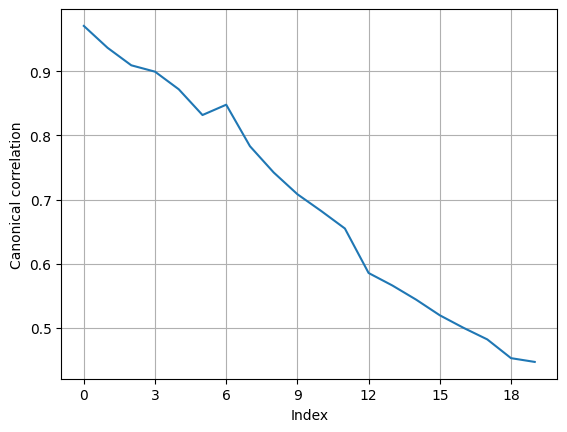

In [26]:
# compute distance matrix using all the features
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=20)
# visualize canonical correlations to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(canonical_correlations))), canonical_correlations)
ax.set(xlabel='Index', ylabel='Canonical correlation')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

Seems like 18 provides the best

In [27]:
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=18)
# perform the refined matching
_ = mario.match_cells('all', sparsity=None, mode='auto')

**Optional**: Similarly if we have the basic annotations we can test the performance of matching. Note although the increase of accuracy is not significant, the annotation is only very basic and broad, and the matching accuracy will see a larger raise if there is more underlying information hiding in the non-overlapping features/ or the annotations is more specific.

In [28]:
# evaluate accuracy
eval_matching_accuracy(\
    input_cite_labels, 
    test_labels, 
    mario.matching['all'], 
    'maj')

0.2361868526738533

### [Optional] MARIO Matchability test

However, in most cases we don't have an annotation file to quickly validate if the matching of MARIO is solid. Moreover, many datasets should not be forcefully match and integrated (due to underlying biology or poor quality data). Therefore, we provide a rigorous statistical testing to confirm the two dataset can be matched. Note this step could be slow depending on the datasize and parameter selected: 

In [29]:
# mario.matchable(n_sim=20, top_k=5, flip_prob=0.2, subsample_prop=1, verbose=True)

The test will give you two p values (#1 for ovlp matching, #2 for all matching). We suggest **not to perform** a matching/integration analysis of any kind on datasets with an anverage $p > 0.05$.

### Find the best interpolation of overlapping and all matching

Then we can find the best balance between the ```ovlp``` feature matching and ```all``` feature mathcing by the interpolate function. The best weight will be finded and the corresponding match will be stored inside the object:

In [30]:
best_wt, _ = mario.interpolate(n_wts=5, top_k=5, verbose=True)

Now at iteration 0, wt=0.0
Now at iteration 1, wt=0.25
Now at iteration 2, wt=0.5
Now at iteration 3, wt=0.75
Now at iteration 4, wt=1.0


### Joint regularized filtering of sub-optimal matching

At the very last step, we will filter out the potential sub-optimal matching pairs via joint regularized filtering. The filtering will be formed on the matching based on weighted interpolation. The parameter ```n_clusters``` should be approximately be the number of cell populations, and ```n_components``` will be the number of components used during filtering, suggest using number in between the components used during ```ovlp``` and ```all``` matching. The parameter ```bad_prop``` controls the filtering strength and will be more stringent if increased, we suggest using $0.1$ - $0.3$. After filtering, matched cell pairs will be less rows of original data ```df1_sub```.

In [31]:
_  = mario.filter_bad_matches(
    'wted', n_clusters=25, n_components=15, bad_prop=0.2,
    max_iter=30, tol=1e-5, verbose=True
)

Now at iteration 0, current loss is -6.217547448890392.
Now at iteration 1, current loss is -6.387463697375449.
Now at iteration 2, current loss is -6.417885714751443.
Now at iteration 3, current loss is -6.429805201806842.
Now at iteration 4, current loss is -6.440963327551325.
Now at iteration 5, current loss is -6.450910664571095.
Now at iteration 6, current loss is -6.45574550686367.
Now at iteration 7, current loss is -6.458437363364498.
Now at iteration 8, current loss is -6.460738947179418.
Now at iteration 9, current loss is -6.4631200406920195.
Now at iteration 10, current loss is -6.465146231418604.
Now at iteration 11, current loss is -6.466643090706152.
Now at iteration 12, current loss is -6.467720460290402.
Now at iteration 13, current loss is -6.468453675605867.
Now at iteration 14, current loss is -6.468957867848548.
Now at iteration 15, current loss is -6.46929362030382.
Now at iteration 16, current loss is -6.469466614786132.
Now at iteration 17, current loss is -6.46

### Matching result access

All the matching produced by MARIO are stored in object ```mario.matching``` and different matching results can be accessed via keys eg. ```ovlp```, ```all```,```wted```, ```final```. The matching result contains a list of numbers which corresponding of the matching rows (eg. ```mario.matching['final'][0]``` is 41, meaning 0th row of ```df1_sub``` is matched to 41th row of ```df2_sub```. Empty means match pair beeing removed after filtering. Here we reformat the matching result to a pd dataframe for checking:

In [32]:
## reformat the MARIO matching results to a dataframe
df1_rowidx=list(range(len(mario.matching['final']))) # extract the final matching
filtered_out=[i for i,x in enumerate(mario.matching['final']) if not x]
match_final_df1 =[e for e in df1_rowidx if not e in filtered_out]
match_final_df2 = [item for sublist in mario.matching['final'] for item in sublist]
matching_final_df = pd.DataFrame(np.column_stack([match_final_df1, match_final_df2]))
matching_final_df

,0,1
0,0,397
1,1,22227
2,2,21041
3,3,9179
4,4,7261
...,...,...
23650,23650,4589
23651,23651,23718
23652,23652,4847
23653,23653,19834


**optional**: We also provides the option to do the standard k-NN matching of the MARIO matched pairs:

In [33]:
_ = mario.knn_matching('wted', k=5)

### Joint embedding

With the cells having high quality pairs, we can use CCA to produce the sub-space scores, that can be used for downstream analysis eg. visualization with t-sne/umap, joint clustering and more.

In [34]:
_, cca = mario.fit_cca(mario.matching['final'], n_components=10, max_iter=10000)
df1_sub_cca, df2_sub_cca = cca.x_scores_, cca.y_scores_

Optionally, if we have the labels, we can also quickly check how the matching was performing after filtering, and we will see a furthur increase in matching accuracy:

In [35]:
# # evaluate accuracy
# eval_matching_accuracy(\
#     input_cite_labels, 
#     test_labels, 
#     mario.matching['final'], 
#     'maj')

0.2361868526738533

In [43]:
input_cca = pd.DataFrame(\
    df1_sub_cca,
    index=ari_adt_rna.T.index.values,
    columns=['cca_{}'.format(i) for i in range(1,df1_sub_cca.shape[1]+1)])
input_cca.reset_index().to_feather("output/mario_outputs/cite_ari_groups_cca.fea")
input_cca

,cca_1,cca_2,cca_3,cca_4,cca_5,cca_6,cca_7,cca_8,cca_9,cca_10
TTTGTTGTCTTGGAAC-1.AS_CITE_CD127,0.849676,0.580278,1.455778,-1.557676,0.645309,0.129200,-0.653488,-0.124773,-0.081894,-0.155279
TCATTTGAGAGATTCA-1.AS_CITE_CD127,0.719710,0.571973,1.919220,-1.124482,-0.162673,-0.325158,-0.013416,-0.093854,0.236186,0.017924
ATCCTATGTTCTCTAT-1.AS_CITE_CD127,1.189468,0.017469,1.495168,0.565635,-0.350143,-0.160093,0.258336,-0.136378,0.381360,-0.469402
GAGATGGGTATGAGGC-1.AS_CITE_CD127,0.031858,0.101960,-0.105810,-1.348771,0.050673,1.089952,-0.509844,-0.467362,0.809848,-0.056095
TCATTGTTCTGGACTA-1.AS_CITE_CD127,0.847366,0.186558,0.334408,0.230071,-0.197572,2.269237,1.039937,-1.184154,0.353953,-1.161860
...,...,...,...,...,...,...,...,...,...,...
AACCTTTAGAAGGCTC-1.AS_3CITE_Kitx2,-0.295130,-1.640863,-0.057727,0.055394,-0.284357,-0.183744,-0.401200,1.162933,-0.769063,0.042400
CCTGCATGTACAGGTG-1.AS_3CITE_Kit,0.024849,-1.309310,0.068026,0.109435,-1.054775,1.091201,-0.873235,1.468840,0.495756,0.440404
GCAGGCTTCTTTGCGC-1.AS_CITE_Kit,-0.342554,-1.353022,0.224711,0.063808,-0.171362,-0.580167,-0.145595,1.043275,-0.017903,-0.113819
TGCAGGCTCCAGTGCG-1.AS_3CITE_Kitx2,-0.473831,-1.485158,0.039812,0.254572,-0.086663,-0.285214,-0.146012,1.105030,-0.047135,-0.235813


In [46]:
flow_cca = pd.DataFrame(\
    df2_sub_cca,
    columns=['cca_{}'.format(i) for i in range(1,df2_sub_cca.shape[1]+1)])
flow_cca.to_feather("output/mario_outputs/inflow_ari_gates_cca_all_cells_mapped_adt_alone.fea")
flow_cca


,cca_1,cca_2,cca_3,cca_4,cca_5,cca_6,cca_7,cca_8,cca_9,cca_10
0,1.666400,1.136058,2.912633,-4.499826,1.123661,0.438108,-1.838099,-0.465881,0.230977,-0.714533
1,1.430842,1.546136,4.918419,-2.414852,-1.388710,-0.942828,1.530352,-0.340298,-0.334730,0.771475
2,2.325024,-0.212613,3.015571,2.246328,-0.555728,-0.738240,0.555482,-0.011862,0.874470,-0.793064
3,-0.941077,0.415247,-0.224337,-4.618703,0.959249,1.462010,-0.815111,-1.140544,1.086284,-0.201687
4,1.380451,0.081586,0.790025,0.969688,-0.448928,2.133054,1.608897,-0.932766,-0.006219,-1.405629
...,...,...,...,...,...,...,...,...,...,...
23650,-0.357289,-2.885719,0.666562,-0.680010,-0.215939,-0.436730,-1.211279,2.084686,-0.321499,-0.036863
23651,-0.657079,-2.640282,1.025962,0.141454,-2.044683,1.524408,-1.615225,1.746489,0.240109,1.271543
23652,-0.288074,-2.734065,0.681457,-0.037803,0.047338,-0.428499,-0.473323,2.038000,0.454682,0.225010
23653,-1.012067,-2.363196,0.132192,0.334744,-0.655056,-0.289286,0.414011,1.528115,0.206644,0.101633


In [45]:
# pd.DataFrame({\
#     "cell": test.index.values,
#     "groups": test_labels}).to_csv(\
#         "output/mario_outputs/inflow_gated_ari.csv",
#         header=True, index=False)

In [48]:
# Build kNN classifier to map labels from CITE-seq to InfinityFlow
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(input_cca.values, input_cite_labels)
inflow_preds = neigh.predict(flow_cca)

In [89]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(\
    test_labels[mario.matching["final"]].reshape(-1), 
    inflow_preds)

0.20819977092816935

In [90]:
cite_centroids = ari_adt_rna.T.copy()
cite_centroids["cluster"] = input_cite_labels
cite_centroids = pd.pivot_table(cite_centroids, index="cluster", aggfunc=np.mean)
cite_centroids

,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-100:anti_mouse_human_CD44:CD44,ADT_Link-102:anti_mouse_rat_CD29:CD29,ADT_Link-103:anti_mouse_rat_CD61:CD61,ADT_Link-104:anti_mouse_rat_CD81:CD81,ADT_Link-105:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-10:CD14:CD14,ADT_Link-11:CD140a:CD140a,ADT_Link-12:CD150_SLAM:BV711-A,ADT_Link-13:CD155_PVR:CD155,...,RNA_Link-89:Ly6c2:BV570-A,RNA_Link-8:Il7r:BV785-A,RNA_Link-90:Ly6g:AlexaFluor700-A,RNA_Link-93:Pirb:PIR_A_B,RNA_Link-94:Siglech:SiglecH,RNA_Link-96:Timd4:TIM4,RNA_Link-97:Itga6:CD49f,RNA_Link-98:Itgb7:BUV615-A,RNA_Link-99:Itgam:BV750-A,RNA_Link-9:Flt3:PE-Cy5-A
cluster,,,,,,,,,,,,,,,,,,,,,
CD127,0.366978,0.650376,0.547770,0.310098,0.533710,0.746493,0.241608,0.168520,0.365029,0.626053,...,0.001768,0.623639,0.000000,0.000587,0.064853,0.000300,0.048133,0.046145,0.007974,0.567439
CFU-E,0.293535,0.571002,0.636677,0.179555,0.672492,0.275788,0.201548,0.145075,0.355930,0.179123,...,0.074585,0.215951,0.173974,0.093178,0.109228,0.126393,0.261857,0.080937,0.082017,0.123792
HSCP,0.380846,0.572614,0.583027,0.338295,0.628738,0.712357,0.240562,0.169029,0.390106,0.567126,...,0.000000,0.000092,0.000000,0.003776,0.000000,0.006225,0.405334,0.054272,0.006857,0.291710
IG2,0.246955,0.773318,0.730842,0.433129,0.654262,0.631808,0.179801,0.146383,0.340521,0.814254,...,0.464232,0.102669,0.083368,0.044816,0.051628,0.059568,0.384153,0.036946,0.079399,0.070430
Ly6C-1,0.345478,0.369372,0.566925,0.198130,0.712887,0.302628,0.219673,0.156271,0.348000,0.766457,...,0.051556,0.130211,0.100112,0.056117,0.067226,0.078939,0.371600,0.209418,0.051839,0.089695
Ly6C-2,0.368083,0.430873,0.579794,0.236638,0.706689,0.550856,0.225670,0.160653,0.358761,0.743315,...,0.031858,0.098322,0.075791,0.048749,0.048844,0.058712,0.334317,0.218621,0.042384,0.078165
Ly6C-3,0.439298,0.622595,0.695762,0.309799,0.728404,0.509124,0.259964,0.181353,0.379512,0.926191,...,0.073348,0.154349,0.114114,0.059589,0.073083,0.085720,0.299892,0.062594,0.080263,0.103447
Ly6C-4,0.313769,0.619273,0.671265,0.425502,0.615151,0.695529,0.202759,0.152748,0.355313,0.760660,...,0.087947,0.047125,0.036842,0.019153,0.023204,0.026614,0.353386,0.030822,0.032438,0.064299
MkP,0.335570,0.568934,0.733561,0.361507,0.736071,0.418282,0.215754,0.153714,0.556175,0.282268,...,0.023028,0.067239,0.051372,0.027545,0.033128,0.036576,0.486998,0.027800,0.044470,0.038160


In [91]:
"""
Cells should be in index for both dataframes
"""
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))

In [96]:
test_corrs = pearson_corr_df_to_df(cite_centroids.T, test.T).T

In [102]:
(test_labels == test_corrs.idxmax(axis=1).values).sum()


11504

In [103]:
adjusted_rand_score(\
    test_labels, 
    test_corrs.idxmax(axis=1).values)

0.3541845210867264